### Slider control of `Common-Rig`

In [32]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import MultiSliderClass
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[3.1.2]


### Parse `scene_common_rig_psyonic.xml`

In [33]:
xml_path = '../asset/smplh_rig/scene_smplh_rig.xml'
env = MuJoCoParserClass(name='Common-Rig',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    for geom_idx in env.get_geom_idxs_from_body_name(body_name=body_name):
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0020] HZ:[500]
n_dof (=nv):[70]
n_geom:[67]
geom_names:['floor', 'base', 'base2lpelvis', 'base2rpelvis', 'base2spine1', 'spine12spine2', 'spine22spine3', 'spine32neck', 'spine32lcollar', 'spine2rcollar', 'neck2head', 'head', 'nose', 'lcollar2lshoulder', 'lshoulder2lelbow', 'lelbow2lwrist', 'lwrist2lindex1', 'lwrist2lmiddle1', 'lwrist2lpinky1', 'lwrist2lring1', 'lwrist2lthumb1', 'lindex1-lindex2', 'lindex2-lindex3', 'lindex3-lindextip', 'lmiddle1-lmiddle2', 'lmiddle2-lmiddle3', 'lmiddl3-lmiddletip', 'lpinky1-lpinky2', 'lpinky2-lpinky3', 'lpinky3-lpinkytip', 'lring1-lring2', 'lring2-lring3', 'lring3-lringtip', 'lthumb1-lthumb2', 'lthumb2-lthumb3', 'lthumb3-lthumbtip', 'rcollar2rshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rwrist2rindex1', 'rwrist2rmiddle1', 'rwrist2rpinky1', 'rwrist2rring1', 'rwrist2rthumb1', 'rindex1-rindex2', 'rindex2-rindex3', 'rindex3-rindextip', 'rmiddle1-rmiddle2', 'rmiddle2-rmiddle3', 'rmiddle3-rmiddletip', 'rpinky1-rpinky2', 'rpinky2-rpinky3', 'rpinky3-

### Slider Control

Pressed ESC
Quitting.


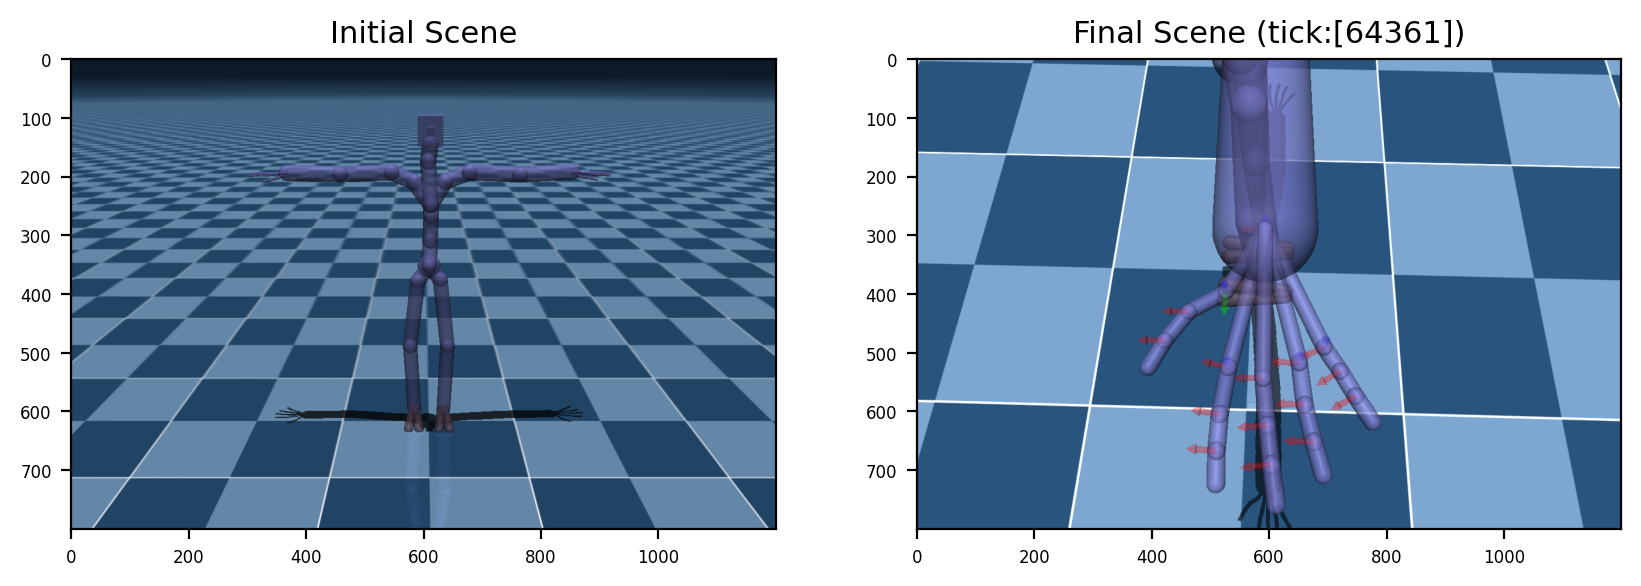

In [34]:
HAND_COUPLING = False

# Initialize sliders for joint control with coupling
ctrl_joint_names = env.ctrl_names
idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
q_ctrl = env.get_qpos_joints(ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

sliders = MultiSliderClass(
    n_slider      = n_ctrl_joint,
    title         = 'Sliders for Common-Rig Control',
    window_width  = 500,
    window_height = 800,
    x_offset      = 300,
    y_offset      = 100,
    slider_width  = 350,
    label_texts   = ctrl_joint_names,
    slider_mins   = env.ctrl_joint_mins,
    slider_maxs   = env.ctrl_joint_maxs,
    slider_vals   = q_ctrl,
    resolution    = 0.01,
    VERBOSE       = False
)
for _ in range(100): sliders.update() # to avoid GIL-related error

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Common-Rig',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
# env.update_viewer(azimuth=180,distance=3.0,elevation=-21,lookat=[0.02,-0.03,0.8])
env.update_viewer(
    azimuth=-88.42500000000014,
    distance=2.2662390527868883,
    elevation=-64.20000000000005,
    lookat=[-0.06, -0.03, -0.25])
# Reset and loop
env.reset()
FIRST_FLAG = True

while env.is_viewer_alive() and sliders.is_window_exists():
    # Simulate
    sliders.update() # update slider control
    q_fwd = sliders.get_slider_values()

    env.data.qpos[idxs_fwd] = q_fwd

    if HAND_COUPLING:
        q_couple = env.data.qpos.copy()

        coupled_joint_idx_list = [[22,23],[24,25,26],[27,28,29],[30,31,32],[33,34,35],
                                  [45,46],[47,48,49],[50,51,52],[53,54,55],[56,57,58]]

        coupled_joint_weights_list = [[1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],
                                      [1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2]]

        for i in range(len(coupled_joint_idx_list)):
            coupled_joint_idx = coupled_joint_idx_list[i]
            coupled_joint_weights = coupled_joint_weights_list[i]
            joint_sum = 0

            for j in range(len(coupled_joint_idx)):
                joint_sum += env.data.qpos[coupled_joint_idx[j]]

            joint_sum /= np.sum(coupled_joint_weights)

            for k in range(len(coupled_joint_idx)):
                q_couple[coupled_joint_idx[k]] = joint_sum*coupled_joint_weights[k]

        env.forward(q=q_couple,INCREASE_TICK=True)

    else:
        env.forward(q=env.data.qpos,INCREASE_TICK=True)
    
    if env.loop_every(tick_every=10):
        # Plot world frame
        # env.plot_T(p=np.zeros(3),R=np.eye(3,3),
        #            PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        
        # # Text information
        # env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3),PLOT_AXIS=False,
        #            label='Tick:[%d]'%(env.tick))
        
        # # Plot bodies
        # for body_name in env.body_names:
        #     p,R = env.get_pR_body(body_name=body_name)
        #     env.plot_T(p=p,R=R,PLOT_AXIS=False,axis_len=0.1,axis_width=0.005)
        
        # Plot revolute joints with arrow
        for rev_joint_idx,rev_joint_name in zip(env.rev_joint_idxs,env.rev_joint_names):
            axis_joint = env.model.jnt_axis[rev_joint_idx]
            p_joint,R_joint = env.get_pR_joint(joint_name=rev_joint_name)
            axis_world = R_joint@axis_joint
            axis_rgba = np.append(np.eye(3)[:,np.argmax(axis_joint)],0.2)
            axis_len,axis_r = 0.02,0.002
            env.plot_arrow_fr2to(
                p_fr=p_joint,p_to=p_joint+axis_len*axis_world,
                r=axis_r,rgba=axis_rgba)
        # Plot contact information
        # env.plot_contact_info(h_arrow=0.3,rgba_arrow=[1,0,0,1],
        #                       PRINT_CONTACT_BODY=True)
        env.render()
        
    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
    if env.is_viewer_alive() and env.loop_every(tick_every=100):
        scene_img_final = env.grab_image()
    FIRST_FLAG = False
        
# Close MuJoCo viewer and sliders
env.close_viewer()
sliders.close()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()

In [35]:
env.get_viewer_cam_info()

(-88.42500000000014,
 2.2662390527868883,
 -64.20000000000005,
 array([-0.06, -0.03, -0.25]))

In [36]:
import math

a = "-0.002027 0.113820 -0.007885"
a1 = a.split()[0]
a1 = np.float32(a1)
a2 = a.split()[1]
a2 = np.float32(a2)
a3 = a.split()[2]
a3 = np.float32(a3)

theta = math.atan2(-a1,a2)
print("theta: ", np.degrees(theta))

b = "-0.003684 0.031937 0.000394"
b1 = b.split()[0]
b1 = np.float32(b1)
b2 = b.split()[1]
b2 = np.float32(b2)
b3 = b.split()[2]
b3 = np.float32(b3)

len_b = math.sqrt(b1**2 + b2**2)
alpha = math.atan2(-b1,b2)
print("alpha: ", np.degrees(alpha))

c = "-0.003287 0.024481 -0.002376"
c1 = c.split()[0]
c1 = np.float32(c1)
c2 = c.split()[1]
c2 = np.float32(c2)
c3 = c.split()[2]
c3 = np.float32(c3)

len_c = math.sqrt(c1**2 + c2**2)
beta = math.atan2(-c1,c2)
print("beta: ", np.degrees(beta))

gamma = alpha - theta
print("gamma: ", np.degrees(gamma))
delta = beta - alpha
print("delta: ", np.degrees(delta))

angle1 = np.round(gamma, 7)
angle2 = np.round(delta, 7)

print("pos=\"%f %f %f\" euler=\"0 0 %f\"" % (a1, a2, a3, theta))
print("pos=\"%f %f %f\" euler=\"0 0 %f\"" % (-len_b*math.sin(angle1),len_b*math.cos(angle1), b3, angle1))
print("pos=\"%f %f %f\" euler=\"0 0 %f\"" % (-len_c*math.sin(angle2),len_c*math.cos(angle2), c3, angle2))

theta:  1.0202624480615026
alpha:  6.5801064189364915
beta:  7.647219829664298
gamma:  5.559843970874989
delta:  1.067113410727806
pos="-0.002027 0.113820 -0.007885" euler="0 0 0.017807"
pos="-0.003115 0.031998 0.000394" euler="0 0 0.097038"
pos="-0.000460 0.024696 -0.002376" euler="0 0 0.018625"
